In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
# External dependencies
# pip install geopy graphviz folium
import folium
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
from scipy.stats import norm, skew

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
BATCH_SIZE = 32

In [0]:
#trip_weather_station_ID = pickle.load(open("/content/drive/My Drive/Data/Bikes_data/data/trip_weather_station_ID.pickle", "rb"))
trip_weather_station_ID = pickle.load(open("/content/drive/My Drive/Data/Bikes_data/data/trip_weather_station_merge.pickle", "rb"))

weather_station_dup = pickle.load(open("/content/drive/My Drive/Data/Bikes_data/data/weather_station_dup.pickle", "rb"))
station_data_orig = pd.read_csv("/content/drive/My Drive/Data/Bikes_data/data/station_data.csv")
trip_data_orig = pd.read_csv('/content/drive/My Drive/Data/Bikes_data/data/trip_data.csv')

In [0]:
trip_weather_station_ID.drop(['index_x', 'index_y'], axis = 1, inplace = True) # Dropping two columns

In [0]:
trip_weather_station_ID.head()

,Start Date,Start Station,End Station,net_change_bikes,total_bikes_change,total_bikes_pct_change,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressureIn,Mean Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,City,Id,Dock Count
0,2014-01-09 08:00:00,1,0.0,-1.0,-1.0,NaN,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,290.0,San Francisco,47.0,19.0
1,2014-01-09 09:00:00,0,0.0,0.0,-1.0,0.0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,290.0,San Francisco,47.0,19.0
2,2014-01-09 10:00:00,0,0.0,0.0,-1.0,0.0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,290.0,San Francisco,47.0,19.0
3,2014-01-09 11:00:00,0,0.0,0.0,-1.0,0.0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,290.0,San Francisco,47.0,19.0
4,2014-01-09 12:00:00,2,2.0,0.0,-1.0,0.0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,29.86,29.82,29.76,10.0,10.0,8.0,16.0,7.0,20.0,0.0,0.0,290.0,San Francisco,47.0,19.0


In [0]:
trip_weather_station_ID['Time'] = trip_weather_station_ID['Start Date'].dt.time   # Adding "Time" column to the dataframe, which gives time on the particular day
trip_weather_station_ID['dayofweek'] = trip_weather_station_ID['Start Date'].dt.dayofweek # Adding "dayofweek" column to the dataframe, which gives information about the day
trip_weather_station_ID['month'] = trip_weather_station_ID['Start Date'].dt.month   # Adding "month" column to the dataframe, which gives information about the day
trip_weather_station_ID['Hour'] = trip_weather_station_ID['Start Date'].dt.hour 
trip_weather_station_ID['Dayofyear'] = trip_weather_station_ID['Start Date'].dt.dayofyear 

In [0]:
trip_weather_station_ID.keys()

Index(['Start Date', 'Start Station', 'End Station', 'net_change_bikes',
       'total_bikes_change', 'total_bikes_pct_change', 'Date',
       'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       'Mean Humidity', 'Min Humidity', 'Max Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Min Sea Level PressureIn',
       'Max VisibilityMiles', 'Mean VisibilityMiles', 'Min VisibilityMiles',
       'Max Wind SpeedMPH', 'Mean Wind SpeedMPH', 'Max Gust SpeedMPH',
       'PrecipitationIn', 'CloudCover', 'WindDirDegrees', 'City', 'Id',
       'Dock Count', 'Time', 'dayofweek', 'month', 'Hour', 'Dayofyear'],
      dtype='object')

In [0]:
trip_weather_station_ID_drop = trip_weather_station_ID.copy()

For convenience purposes the weather columns are dropped except "Max Wind Speed", "Max Temperature"

In [0]:
#Dropping the columns that are not necessary
#columns to drop ID,DOCK COUNT ,date, start station, end station, total_bikes_change, total_bikes_pct_change, city, id

#trip_weather_station_ID_drop = trip_weather_station_ID[['Start Date','Start Station', 'End Station', 'Max TemperatureF', 'Max Wind SpeedMPH', 'Min TemperatureF', 'dayofweek', 'month' ,'total_bikes_pct_change','total_bikes_change' , 'net_change_bikes']]
trip_weather_station_ID_drop = trip_weather_station_ID[['Start Date', 'Max TemperatureF','Max Wind SpeedMPH','Max VisibilityMiles', 'Mean TemperatureF','Mean VisibilityMiles',  'dayofweek' ,'Hour' ,'Dayofyear', 'net_change_bikes']]

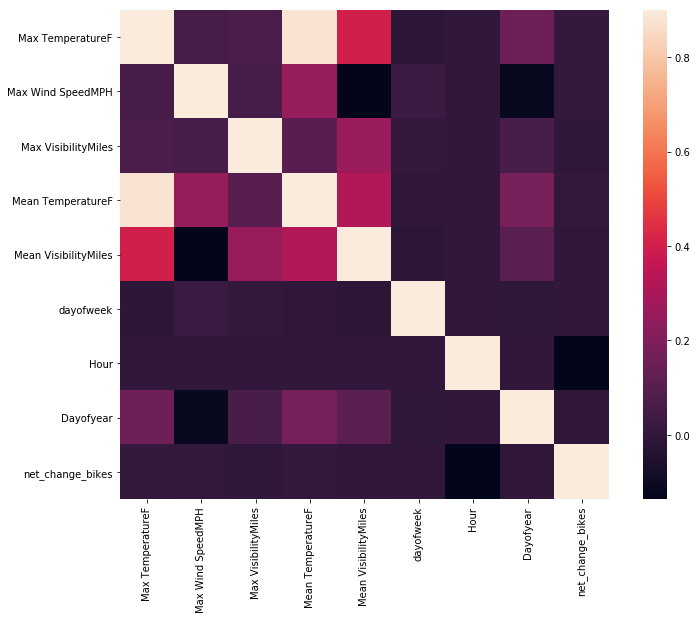

In [0]:
corrmat = trip_weather_station_ID_drop.corr(method = 'pearson')
plt.subplots(figsize = (12,9))
sns.heatmap (corrmat, vmax = 0.9, square = True)

Number of columns to be dropped "Date", "total_bikes_change", "total_bikes_pct_change", "Start Date", 

1.   List item
2.   List item



#Setting up the index column

In [0]:
trip_weather_station_ID_drop.set_index('Start Date', inplace = True)
trip_weather_station_ID_drop.fillna(method = 'ffill', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [0]:
trip_weather_station_ID_drop.head()

,Max TemperatureF,Max Wind SpeedMPH,Max VisibilityMiles,Mean TemperatureF,Mean VisibilityMiles,dayofweek,Hour,Dayofyear,net_change_bikes
Start Date,,,,,,,,,
2014-01-09 08:00:00,83.0,16.0,10.0,70.0,10.0,3,8,9,-1.0
2014-01-09 09:00:00,83.0,16.0,10.0,70.0,10.0,3,9,9,0.0
2014-01-09 10:00:00,83.0,16.0,10.0,70.0,10.0,3,10,9,0.0
2014-01-09 11:00:00,83.0,16.0,10.0,70.0,10.0,3,11,9,0.0
2014-01-09 12:00:00,83.0,16.0,10.0,70.0,10.0,3,12,9,0.0


In [0]:
trip_weather_station_ID_drop.dtypes

Max TemperatureF        float64
Max Wind SpeedMPH       float64
Max VisibilityMiles     float64
Mean TemperatureF       float64
Mean VisibilityMiles    float64
dayofweek                 int64
Hour                      int64
Dayofyear                 int64
net_change_bikes        float64
dtype: object

##Applying one hot encoding on the columns "dayofyear",'hour', 'dayofweek'

In [0]:
from sklearn.preprocessing import OneHotEncoder
#instantiate one hot encoder
x_enc = pd.get_dummies(trip_weather_station_ID_drop, columns = ['dayofweek', 'Hour', 'Dayofyear'], drop_first = True)
x_enc.head()


,Max TemperatureF,Max Wind SpeedMPH,Max VisibilityMiles,Mean TemperatureF,Mean VisibilityMiles,net_change_bikes,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Dayofyear_2,Dayofyear_3,Dayofyear_4,Dayofyear_5,Dayofyear_6,...,Dayofyear_326,Dayofyear_327,Dayofyear_328,Dayofyear_329,Dayofyear_330,Dayofyear_331,Dayofyear_332,Dayofyear_333,Dayofyear_334,Dayofyear_335,Dayofyear_336,Dayofyear_337,Dayofyear_338,Dayofyear_339,Dayofyear_340,Dayofyear_341,Dayofyear_342,Dayofyear_343,Dayofyear_344,Dayofyear_345,Dayofyear_346,Dayofyear_347,Dayofyear_348,Dayofyear_349,Dayofyear_350,Dayofyear_351,Dayofyear_352,Dayofyear_353,Dayofyear_354,Dayofyear_355,Dayofyear_356,Dayofyear_357,Dayofyear_358,Dayofyear_359,Dayofyear_360,Dayofyear_361,Dayofyear_362,Dayofyear_363,Dayofyear_364,Dayofyear_365
Start Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-09 08:00:00,83.0,16.0,10.0,70.0,10.0,-1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-09 09:00:00,83.0,16.0,10.0,70.0,10.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-09 10:00:00,83.0,16.0,10.0,70.0,10.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-09 11:00:00,83.0,16.0,10.0,70.0,10.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-09 12:00:00,83.0,16.0,10.0,70.0,10.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Train, validation,test split
It is important to determine the train,test and validation splits according to the data. Parameters of the models are usualy trained and optimized with the train and validation samples.

In [0]:
from sklearn.model_selection import train_test_split
times = sorted(trip_weather_station_ID_drop.index.values)
last_5pct = sorted(trip_weather_station_ID_drop.index.values)[-int(0.2*len(times))]
last_5pct

numpy.datetime64('2015-07-22T05:00:00.000000000')

In [0]:
train_dataset = trip_weather_station_ID_drop[(trip_weather_station_ID_drop.index < last_5pct)]
test_dataset = trip_weather_station_ID_drop[(trip_weather_station_ID_drop.index >= last_5pct)]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'net change in bikes traning dataset')

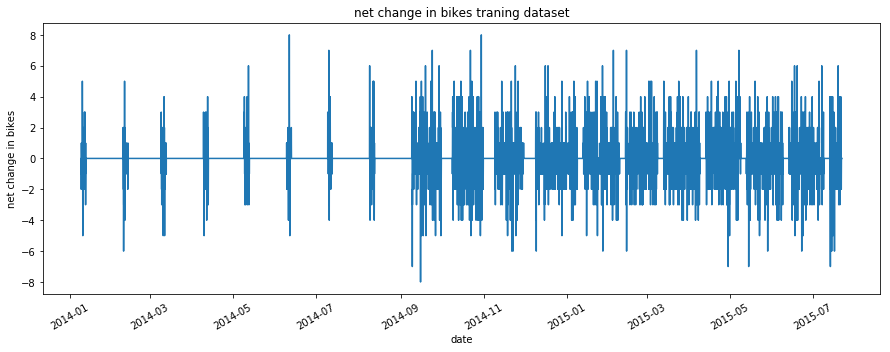

In [0]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

fig,ax = plt.subplots()
train_dataset = train_dataset.sort_index(axis = 0)
ax.plot (train_dataset.net_change_bikes)
plt.xticks(rotation = 30)
plt.xlabel ("date")
plt.ylabel ("net change in bikes")
plt.title ('net change in bikes traning dataset')


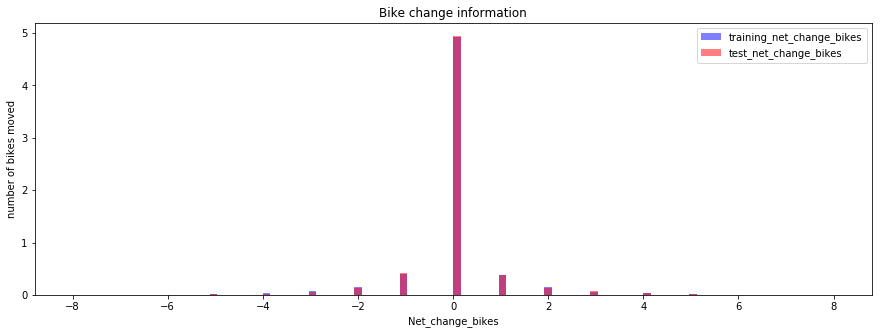

In [0]:
import numpy as np
f,axes = plt.subplots(sharex= True)
#getting bins

bins = np.histogram(np.hstack((train_dataset['net_change_bikes'], test_dataset['net_change_bikes'])), bins = 100)[1]
#Plotting both distributions on same bins
plt.hist (train_dataset['net_change_bikes'], label = "training_net_change_bikes", density = True, bins = bins, fc=(0,0,1,0.5))
plt.hist (test_dataset['net_change_bikes'], label = "test_net_change_bikes", density = True, bins = bins, fc = (1,0,0,0.5))
plt.xlabel ("Net_change_bikes")
plt.ylabel ("number of bikes moved")
plt.title ("Bike change information")
plt.legend ();

##Splitting the train_dataset for validation sample

In [0]:
from sklearn.model_selection import train_test_split

target = "net_change_bikes"

types_ = train_dataset.dtypes

features = list (types_[(types_ == "int64") | (types_ == "float64")].index)
#features = list(types_.index)
features.remove(target)

with open ('feature.pickle', 'wb') as handle:
  pickle.dump (features, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
X = train_dataset[features]
y = train_dataset[target]
X_test = test_dataset[features]
y_test = test_dataset[target]
x_train, x_val, y_train, y_val = train_test_split (X,y, test_size = 0.3, random_state = 42)


In [0]:
print("number of bicycle movement in train set",
      len(y_train[y_train > 0])/(len(y_train)*1.0))
print("number of bicycle movement in validation set",  len(y_val[y_val > 0])/len(y_val))

number of bicycle movement in train set 0.10757269144743849
number of bicycle movement in validation set 0.10039761431411531


#APPLYING THE MODEL

The modelling is an iterative process. The metrics are used to tune the model to achieve the best result. It very important to seed the random splitting of the model, that makes the model to always split in same way which is very important for testing the model on similar dataset.

##Benchmarking

We can now build a first model, let's start with a simple model to use as a benchmark. The benchmark will be used to check whether more complex models imporve the performance .

Here we have a continous target, so we need a regression model. For the regression, linear regression is a good benchmarking model.

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression (normalize = True)
reg.fit(x_train, y_train)
y_pred_val = reg.predict(x_val)
y_pred_train = reg.predict(x_train)

#Model Perfromance

Remember from first session we set a goal and metric, it is now time to use an evaluvation metric to test the perfromance of the model.
To be sure to have the unbiased model, we have to check that the metrics are similar on training and validation sets.

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print ("RMSE on validation ", np.sqrt (mean_squared_error(y_val, y_pred_val)))
print ("RMSE on train", np.sqrt (mean_squared_error (y_train, y_pred_train)))
print ("MAE on validation", mean_absolute_error (y_val,y_pred_val))
print ("MAE on validation", mean_absolute_error (y_train, y_pred_train))

RMSE on validation  0.9533828455332892
RMSE on train 0.9146968584595475
MAE on validation 0.4470047064345804
MAE on validation 0.44517401473748874


At first sight it dose not look bad. Though it is always good to visualize prediction vs real target 

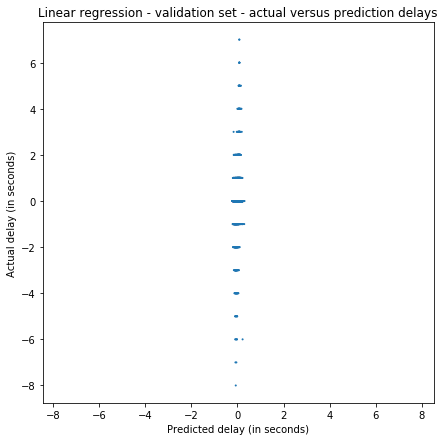

In [0]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

f, axes = plt.subplots(sharex=True)

df = pd.DataFrame({"pred": y_pred_val, "actual": y_val})
df["val"] = 1

group = df.groupby(["pred", "actual"]).count().reset_index()
plt.scatter(group["pred"], group["actual"], s=group["val"])
axes.axis('equal')
plt.xlabel("Predicted delay (in seconds)")
plt.ylabel("Actual delay (in seconds)")
plt.title("Linear regression - validation set - actual versus prediction delays");


#Testing other models

The first model is not bad but we can surely improve the performance using more complex techniques

In [0]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor (random_state = 1, n_estimators = 10)
reg.fit (x_train, y_train)
y_pred_val = reg.predict(x_val)
y_pred_train = reg.predict (x_train)

In [0]:
print ("RMSE on validation ", np.sqrt (mean_squared_error(y_val, y_pred_val)))
print ("RMSE on train", np.sqrt (mean_squared_error (y_train, y_pred_train)))
print ("MAE on validation", mean_absolute_error (y_val,y_pred_val))
print ("MAE on validation", mean_absolute_error (y_train, y_pred_train))


RMSE on validation  0.8983984535339135
RMSE on train 0.3764063698258839
MAE on validation 0.41334493041749504
MAE on validation 0.16541697731387794


We see a worse performance on the validation set than on the training set, but it is a much better performance than the linear regression. Let see if it is confirmed by the plot of actual versus predicted.

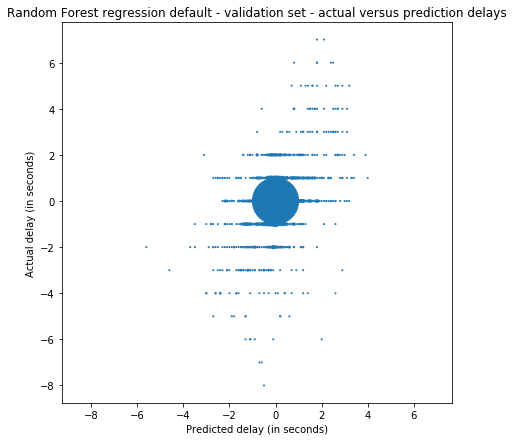

In [0]:
f, axes = plt.subplots(sharex=True)

df = pd.DataFrame({"pred": y_pred_val, "actual": y_val})
df["val"] = 1

group = df.groupby(["pred", "actual"]).count().reset_index()
plt.scatter(group["pred"], group["actual"], s=group["val"])
axes.axis('equal')
plt.xlabel("Predicted delay (in seconds)")
plt.ylabel("Actual delay (in seconds)")
plt.title("Random Forest regression default - validation set - actual versus prediction delays");


When you fit a model and are trying to optimize the parameters, you can only choose to either decrease the variance or the bias. If the bias is very low and the variance very high, the model is said to overfit the training set.

A very good example is with tree ensembles methods:

Random forest combines trees of high dept (low bias and high variance), by doing so, it decreases the variance.
Gradient boosting optimizes the residuals of small trees (high bias and low variance), hence decreasing the bias.

We can try reducing the variance with gradient boosting

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state = 1)
reg.fit (x_train, y_train)
y_pred_train = reg.predict (x_train)
y_pred_val = reg.predict (x_val)

In [0]:
print ("RMSE on validation ", np.sqrt (mean_squared_error(y_val, y_pred_val)))
print ("RMSE on train", np.sqrt (mean_squared_error (y_train, y_pred_train)))
print ("MAE on validation", mean_absolute_error (y_val,y_pred_val))
print ("MAE on validation", mean_absolute_error (y_train, y_pred_train))

RMSE on validation  0.8703397047757271
RMSE on train 0.8287351362709472
MAE on validation 0.4418010101518979
MAE on validation 0.4390679308098004


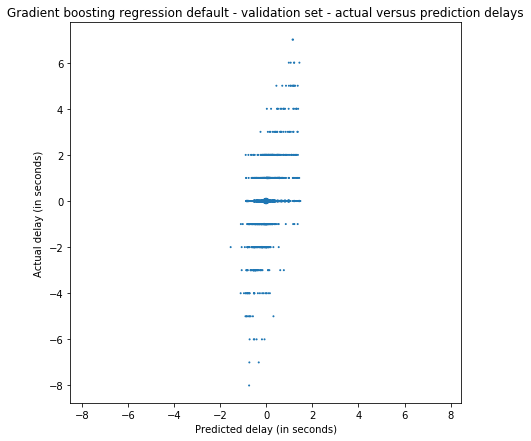

In [0]:
f, axes = plt.subplots(sharex=True)

df = pd.DataFrame({"pred": y_pred_val, "actual": y_val})
df["val"] = 1

group = df.groupby(["pred", "actual"]).count().reset_index()
#print (group)

plt.scatter(group["pred"], group["actual"], s=group["val"]) #, s=group["val"]
axes.axis('equal')
plt.xlabel("Predicted delay (in seconds)")
plt.ylabel("Actual delay (in seconds)")
plt.title("Gradient boosting regression default - validation set - actual versus prediction delays");

#Model Optimization

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline

rmse_scorer = make_scorer (metrics.mean_absolute_error, greater_is_better = True)

pipe = Pipeline ([("regressor", None)])

gbt = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor (random_state = 42)

parameters = [{"regressor": [rf],
              "regressor__n_estimators": range(20,150,25),
              "regressor__max_depth": range(10,30,5)},
             {"regressor" : [gbt],
             "regressor__n_estimators": range(100,500,25),
             "regressor__max_depth": range(3,5)}]

grid_search = GridSearchCV(pipe, parameters, cv=5, scoring = rmse_scorer)
grid_search.fit(X, y)

#print (grid_search.cv_results_)
print (grid_search.best_estimator_)

Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=25, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=20, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)


In [0]:
reg = grid_search.best_estimator_


###For getting feature importance, I am taking the best estimator and reassigning it again.

This is because I want to test the error 

In [0]:
reg = RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=25, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=20, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False)

In [0]:
reg.fit (x_train, y_train)
y_pred_train = reg.predict(x_train)
y_pred_val = reg.predict(x_val)

print ("RMSE on validation ", np.sqrt (mean_squared_error(y_val, y_pred_val)))
print ("RMSE on train", np.sqrt (mean_squared_error (y_train, y_pred_train)))
print ("MAE on validation", mean_absolute_error (y_val,y_pred_val))
print ("MAE on validation", mean_absolute_error (y_train, y_pred_train))

RMSE on validation  0.8890125753123339
RMSE on train 0.35001527755575323
MAE on validation 0.4124184554037786
MAE on validation 0.1594656340366152


#Applying algorithm on test data set

In [0]:
y_pred_test = reg.predict(X_test)
print("RMSE on out of time set ", np.sqrt (mean_squared_error(y_test,
                                                             y_pred_test)))
print("MAE on out of time set", np.sqrt (mean_absolute_error(y_test,
                                                            y_pred_test)))

RMSE on out of time set  1.0420222417080114
MAE on out of time set 0.7977438024106821


Performances are lower on test dataset , this may be due to unequal distribution of the test and train dataset

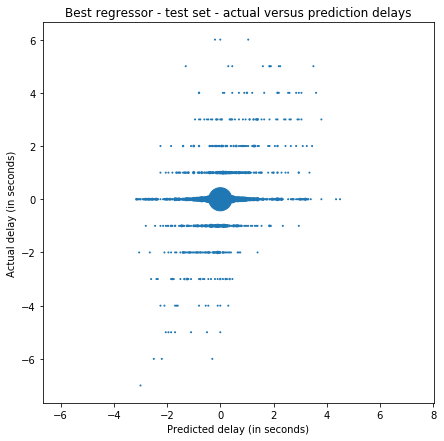

In [0]:
fig,axes = plt.subplots(sharex = True)

df = pd.DataFrame({"pred": y_pred_test, "actual": y_test})
df["val"] = 1

group = df.groupby(["pred", "actual"]).count().reset_index()
plt.scatter(group["pred"], group["actual"], s=group["val"])
axes.axis('equal')
plt.xlabel("Predicted delay (in seconds)")
plt.ylabel("Actual delay (in seconds)")
plt.title("Best regressor - test set - actual versus prediction delays");

##Applying XGBoost 



In [0]:
import xgboost as xgb

reg = xgb.XGBRegressor (objective = 'reg:linear', cosample_bytree = 0.3, learning_rate = 0.1, max_depth = 12,n_estimators = 100 )

reg.fit (x_train,y_train)
y_pred_train = reg.predict (x_train)
y_pred_val = reg.predict (x_val)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
print ("RMSE on validation ", np.sqrt (mean_squared_error(y_val, y_pred_val)))
print ("RMSE on train", np.sqrt (mean_squared_error (y_train, y_pred_train)))
print ("MAE on validation", mean_absolute_error (y_val,y_pred_val))
print ("MAE on validation", mean_absolute_error (y_train, y_pred_train))

RMSE on validation  0.944071239383415
RMSE on train 0.14844149100475962
MAE on validation 0.43941057943711226
MAE on validation 0.06908915449869825


##Applying K-fold XGBoost


In [0]:
data_dmatrix = xgb.DMatrix (data = X, label = y)
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.3, 'learning_rate' : 0.1, 'max_depth' : 12 }

cv_results = xgb.cv(dtrain = data_dmatrix, params = params, nfold = 5, num_boost_round = 100, early_stopping_rounds = 10, metrics = 'rmse', as_pandas = True, seed = 123 )
cv_results.tail()

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
59,0.775815,0.011892,0.884051,0.028142
60,0.775313,0.011823,0.883822,0.028258
61,0.774243,0.011043,0.883725,0.028379
62,0.773786,0.010666,0.883535,0.028786
63,0.770474,0.013609,0.883077,0.028777


#When are we predicting wrong?

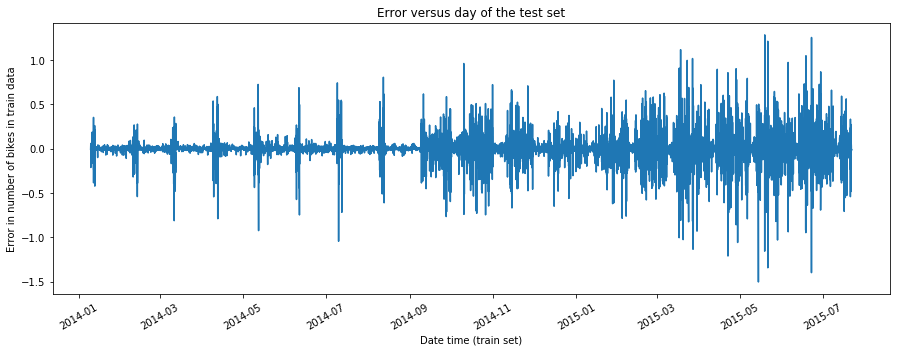

In [0]:
matplotlib.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(sharex=True)


results = pd.DataFrame({"date": x_train.index,
                        "error": y_train-y_pred_train})
results = results.sort_values("date")
axes.plot(results["date"], results["error"])
plt.xticks(rotation=30)
plt.xlabel("Date time (train set)")
plt.ylabel("Error in number of bikes in train data")
plt.title("Error versus day of the test set");

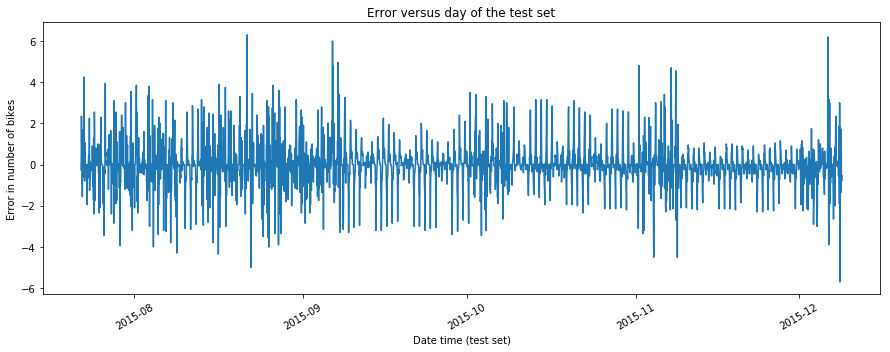

In [0]:
matplotlib.rcParams['figure.figsize'] = [15, 5]

f, axes = plt.subplots(sharex=True)


results = pd.DataFrame({"date": X_test.index,
                        "error": y_test-y_pred_test})
results = results.sort_values("date")
axes.plot(results["date"], results["error"])
plt.xticks(rotation=30)
plt.xlabel("Date time (test set)")
plt.ylabel("Error in number of bikes")
plt.title("Error versus day of the test set");

##Feature Importance

From a tree we can calucuate feature importance, i.e how often this feature was used to split the data. This is a relative importance for the model as a whole and should be interpreted as a ranking.

Text(0.5, 1.0, 'Feature importance from model')

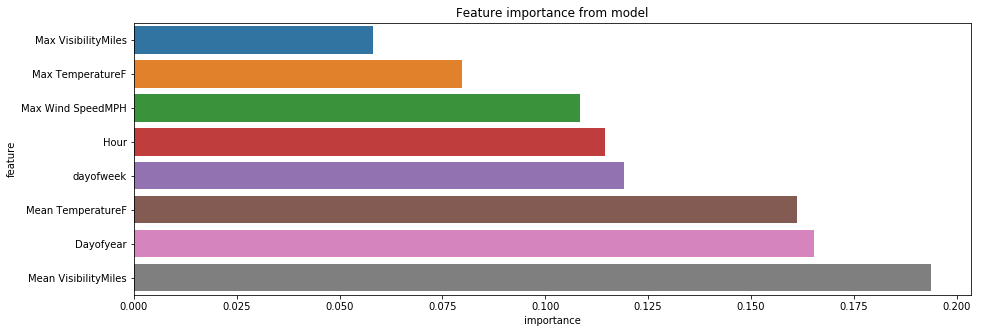

In [0]:
import seaborn as sns
df_features = pd.DataFrame({"feature": features,
                            "importance": reg.feature_importances_})

df_features = df_features [df_features.importance> 0.005].sort_values("importance")
sns.barplot(df_features.importance, df_features.feature)
plt.title ("Feature importance from model")

##Local feature importance
A decision from a tree can be described as a sum of all the features importance that led to the prediction. But these features have a global importance and are not accurate to describe a single prediction. To understand a single prediction, we need to have a local estimator. For this, we draw a sample of features, based on small perturbations of the single observation we which to analyse. Once we have this sample, we run our global model on it, to get an output. Finally, we fit a local model on the newly created sample of data. The features of that tree are now used to describe the prediction obtained. More on the tree

In [0]:
!pip install shap


     |████████████████████████████████| 235kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/3f/4a/331cf71b5043416aeba0df795e7c204c7ad277673f1938d11b
Successfully built shap


In [0]:
import shap
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test.iloc[0:100, :])

print ("predictions", reg.predict(X_test.iloc[0:10,:]))
print ("actual", list (y_test.iloc[0:10]))


predictions [ 0.57803154  0.30194533  1.5795733   2.253162    1.0757663   0.5803181
  0.44044635  0.22170979 -0.24274278 -1.4383091 ]
actual [0.0, 1.0, 4.0, 4.0, 3.0, 0.0, -1.0, 0.0, 0.0, 0.0]


In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5,:], X.iloc[5,:])


From the local approach, you also have a better view on what is the impact of each feature value: if the value of one feature is high, is this important for the model or not?

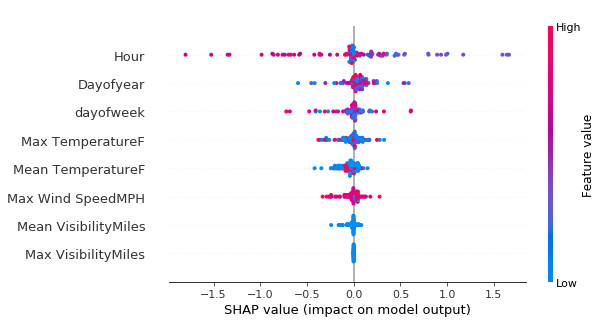

In [0]:
shap.summary_plot(shap_values, X_test.iloc[0:100,:])

#Predicting the model current output of net change in bikes at given station

###For doing this, the current datetime is taken from the computer is registered and with weather values picked up randomly from the dataset the net change in bikes at any given station is predicted for current time.


In [0]:
import datetime
datetime.datetime.now()

datetime.datetime(2019, 6, 7, 11, 26, 29, 45208)

In [0]:
current_test = x_train.columns
print (current_test)
selected_columns = current_test [:-3]
print (selected_columns)
print (x_train[selected_columns].iloc[:1])

Index(['Max TemperatureF', 'Max Wind SpeedMPH', 'Max VisibilityMiles',
       'Mean TemperatureF', 'Mean VisibilityMiles', 'dayofweek', 'Hour',
       'Dayofyear'],
      dtype='object')
Index(['Max TemperatureF', 'Max Wind SpeedMPH', 'Max VisibilityMiles',
       'Mean TemperatureF', 'Mean VisibilityMiles'],
      dtype='object')
                     Max TemperatureF  ...  Mean VisibilityMiles
Start Date                             ...                      
2015-07-16 11:00:00              76.0  ...                  10.0

[1 rows x 5 columns]


In [0]:
#The columns that need to be created are:
#Start Date', 'Max TemperatureF', 'Max Wind SpeedMPH', 'Min TemperatureF', 'dayofweek', 'month' ,'total_bikes_pct_change','total_bikes_change' , 'net_change_bikes  

current_time = datetime.datetime.now() # Importing the time from the computer with pandas
#Creating a test 
current_test = x_train.columns    ## Creating a list with randomly picked weather values from the dataset
print (current_test)
selected_columns = current_test [:-3]
print (selected_columns)
selected_random_test_row = x_train[selected_columns].iloc[:1]


df = pd.DataFrame(selected_random_test_row)                     # Creating a dataframe
date_range = pd.to_datetime('today')                  # Date of today no time included  
time_range = pd.date_range("00:00", current_time, freq="1H")  # creating a time range from midnight today to currrent time 
#df_time = pd.DataFrame (time_range)                       
length_time = len(time_range)
length_time
df = pd.concat([df]*length_time)                # Since the weather is just given for day instead of hourly forecast it is taken as constant entire day, so rows are duplicated depending on the time range
lenght_time_df = len(df)
length_time = len(time_range)
print (lenght_time_df)
print (length_time)

df['Date'] = time_range                       # Creating a column with date and time
df['dayofweek'] = df['Date'].dt.dayofweek     # Calculating day of the week
#df['month']= df['Date'].dt.month              # Calculating month
df['Hour'] = current_time.hour
df['Dayofyear'] = df['Date'].dt.dayofyear
#print (df.head())
df.set_index('Date', inplace = True)      # Set DATE as index


Index(['Max TemperatureF', 'Max Wind SpeedMPH', 'Max VisibilityMiles',
       'Mean TemperatureF', 'Mean VisibilityMiles', 'dayofweek', 'Hour',
       'Dayofyear'],
      dtype='object')
Index(['Max TemperatureF', 'Max Wind SpeedMPH', 'Max VisibilityMiles',
       'Mean TemperatureF', 'Mean VisibilityMiles'],
      dtype='object')
12
12


In [0]:
x_train.columns

Index(['Max TemperatureF', 'Max Wind SpeedMPH', 'Max VisibilityMiles',
       'Mean TemperatureF', 'Mean VisibilityMiles', 'dayofweek', 'Hour',
       'Dayofyear'],
      dtype='object')

In [0]:
# #The columns that need to be created are:
# #Start Date', 'Max TemperatureF', 'Max Wind SpeedMPH', 'Min TemperatureF', 'dayofweek', 'month' ,'total_bikes_pct_change','total_bikes_change' , 'net_change_bikes  

# current_time = datetime.datetime.now() # Importing the time from the computer with pandas

# current_test = {'Max TemperatureF' : [78],     # Creating a list with randomly picked weather values from the dataset
#               'Max Wind SpeedMPH' : [18],
#                'Min TemperatureF' : [55]
#                 }


# df = pd.DataFrame(current_test)                     # Creating a dataframe
# date_range = pd.to_datetime('today')                  # Date of today no time included  
# time_range = pd.date_range("00:00", current_time, freq="1H")  # creating a time range from midnight today to currrent time 
# #df_time = pd.DataFrame (time_range)                       
# length_time = len(time_range)
# length_time
# df = pd.concat([df]*length_time)                # Since the weather is daiy forecast it stays same entire day, so rows are duplicated depending on the time range
# lenght_time_df = len(df)
# length_time = len(time_range)
# print (lenght_time_df)
# print (length_time)
# df['Date'] = time_range                       # Creating a column with date and time
# df['dayofweek'] = df['Date'].dt.dayofweek     # Calculating day of the week
# df['month']= df['Date'].dt.month              # Calculating month
# #print (df.head())
# df.set_index('Date', inplace = True)      # Set DATE as index

#Input the current datetime dataframe to model

###Scaling the values of the dataframe

In [0]:
# df1 = df.values
# #x_test_scaled = x_scaler.transform(df.values)

# x_df_scaled = x_scaler.transform(df1)

###Changing the dimensions and applying the model prediction

In [0]:
# x_df =  np.expand_dims(x_df_scaled, axis=0)
# # Use the model to predict the output-signals.
# y_pred_df = model.predict(x_df)
# print (y_pred_df.shape)

#Model prediction

In [0]:
sample_predict = reg.predict(df)
sample_predict

array([-0.8591738, -0.8591738, -0.8591738, -0.8591738, -0.8591738,
       -0.8591738, -0.8591738, -0.8591738, -0.8591738, -0.8591738,
       -0.8591738, -0.8591738], dtype=float32)

##Inverse transforming the output 
The output generated by the model is in between 0 and 1, here that value is converted into normal value that can be easily related to the data


In [0]:
#
#The output of the model is between 0 and 1. Do an inverse map to get back into the scale of the original dataset

y_pred_rescaled_df = sample_predict[0]

#y_pred_rescaled_df = reg.inverse_transform(sample_predict[0])
y_pred_rescaled_df

-0.8591738

###To measure the net change in bikes we need to know the previous hour values and current value, that is the reason that range is applied so that we can extract current value from previous.

In [0]:
# res = [x-y for x, y in zip (y_pred_rescaled_df,y_pred_rescaled_df[1:])]
# print ('Net change in bikes :' , res[-1] )   # The last value referes to the current value and that is printed out .

##Now plotiing the station ID on the map

In [0]:
station_data_orig = pd.read_csv("/content/drive/My Drive/Data/Bikes_data/data/station_data.csv")
station_data_dup = station_data_orig.copy()

In [0]:
city = 'San Francisco'


###Creating a dataframe for the city intersted

In [0]:
map_city = station_data_dup[station_data_dup['City'] == 'San Francisco']

##San Francisco latitude and longitude
37.7749  -122.4194

In [0]:
map_center = [37.7749,-122.4194]
map_zoom = 14
station_map = folium.Map(location=map_center, zoom_start=map_zoom)
#folium.Marker([45, -30], popup='inline implicit popup').add_to(station_map)   ###
coordinates = map_city[['Lat', 'Long',  'Id', 'Name']]
for lat,long, Id, name  in coordinates.values:
  #print (lat,long,Id)
  folium.CircleMarker([lat,long],
                    radius = 15, popup= f'Net change in bikes {y_pred_rescaled_df}{str(Id)}',
                    
                    color = '#dd0000', fill_color = '#dd0000',).add_to(station_map)
station_map